## Notebook 1. 

This notebook is about the modelling of female mosquito counts (2 species combined) without weather information. The input dataset is the polished PSC per house count dataset across 6 years and 4 villages in Burkina Faso. We made ~3300 house visits hence this is the number of rows in the dataset. 

There are several things we want to know: 1) whether there is a difference in the rate of capturing female mosquitoes among the villages, 2) the strength of monthly variation or seasonality, 3) the strength of yearly variation (good year vs bad year), 4) the variation among individual houses (we had random houses and fixed houses so all the counts are not independent), 5) and whether other covariates (e.g. presence of humans and mosquito nets) have any impacts on the rates. 

The main model I use is Poisson glm, as our response variable is mosquito count. You may also find quasi-Poisson and negative binomial glm throughout this notebook. These glms are also valid under some scenarios. 

[Poisson distribution and glm] Let $ Y_i $ be the observed count during the i-th house visit (i-th row of the dataset). Here we assume $ Y_i\sim Poisson(\lambda_i) $, where $ \lambda_i $ is the rate parameter specifically for the i-th row of the dataset. Therefore, each row of observation (count) will have its own rate parameter. So what is $ \lambda_i $? The key here is to model each $\lambda_i$ with our explanatory variables (e.g. which village, which month, which year, number of persons at home etc.), with a log-link. Hence, $log(\lambda_i)=a+b1*x1_i+b2*x2_i+...$

The codes are in R. 

In [1]:
# LOAD R PACKAGES
require(compiler)
enableJIT(3)
setMKLthreads(23)
require(lme4)
require(lmerTest)
require(MASS)

# LOAD DATASET dat1
#setwd('variance/Florian')
load('Per house data PSC 2012 to 2019 polish2.RData')
load('BF_weather.RData')
ls()

Loading required package: compiler


[1] 3

Loading required package: lme4
Loading required package: Matrix
Loading required package: lmerTest

Attaching package: 'lmerTest'

The following object is masked from 'package:lme4':

    lmer

The following object is masked from 'package:stats':

    step

Loading required package: MASS


[1] "BV_weather" "dat1"       "PL_weather" "SK_weather"

### Descriptive statistics
It would be nice to run some summaries and descriptive statistics to get a feel of the dataset. 

In [2]:
# SOME DESCRIPTIVE STATISTICS ON THE RESPONSE VARIABLE, THAT IS, FEMALE MOSQUITO COUNT
cat('overall summary of count')
summary(dat1$count.f)
cat('mean count per month')
by(dat1$count.f, dat1$month.assigned, mean, na.rm=T)
cat('mean count per year')
by(dat1$count.f, dat1$year.assigned, mean, na.rm=T)
cat('mean count per village')
by(dat1$count.f, dat1$village, mean, na.rm=T)

overall summary of count

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   0.000   2.000   9.309   9.000 333.000      29 

mean count per month

dat1$month.assigned: 1
[1] 0.07643312
------------------------------------------------------------ 
dat1$month.assigned: 2
[1] 0.9890909
------------------------------------------------------------ 
dat1$month.assigned: 3
[1] 3.179039
------------------------------------------------------------ 
dat1$month.assigned: 4
[1] 5.808383
------------------------------------------------------------ 
dat1$month.assigned: 5
[1] 16.57831
------------------------------------------------------------ 
dat1$month.assigned: 6
[1] 9.812139
------------------------------------------------------------ 
dat1$month.assigned: 7
[1] 15.21667
------------------------------------------------------------ 
dat1$month.assigned: 8
[1] 14.49857
------------------------------------------------------------ 
dat1$month.assigned: 9
[1] 26.59649
------------------------------------------------------------ 
dat1$month.assigned: 10
[1] 15.98261
------------------------------------------------------------ 
dat1$month.assig

mean count per year

dat1$year.assigned: 2012
[1] 20.18
------------------------------------------------------------ 
dat1$year.assigned: 2013
[1] 10.54603
------------------------------------------------------------ 
dat1$year.assigned: 2014
[1] 4.966587
------------------------------------------------------------ 
dat1$year.assigned: 2017
[1] 8.006803
------------------------------------------------------------ 
dat1$year.assigned: 2018
[1] 7.076142
------------------------------------------------------------ 
dat1$year.assigned: 2019
[1] 7.104505

mean count per village

dat1$village: Bana market
[1] 9.841727
------------------------------------------------------------ 
dat1$village: Bana village
[1] 12.51009
------------------------------------------------------------ 
dat1$village: Pala
[1] 8.112821
------------------------------------------------------------ 
dat1$village: Souroukoudingan
[1] 5.540291

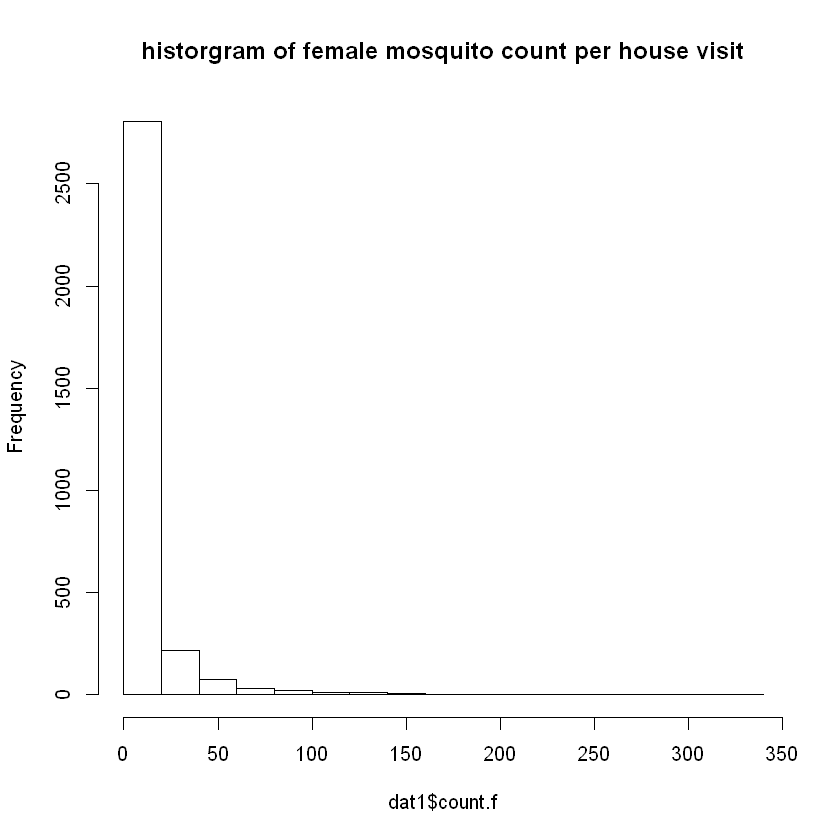

In [3]:
# HISTOGRAM OF THE RESPONSE
hist(dat1$count.f, main='historgram of female mosquito count per house visit')

In [4]:
# DESCRIPTIVE STATS ON SOME EXPLANATORY VARIABLES AS WELL
cat('number of unqiue days of data collection')
length(unique(dat1$date.collection))
cat('number of unique houses we visited')
length(unique(dat1$site.id))
cat('summary of mosquito.net')
by(dat1$mosquito.net, dat1$village, summary)
cat('summary of number of persons in house')
summary(dat1$num.persons)

number of unqiue days of data collection

[1] 164

number of unique houses we visited

[1] 386

summary of mosquito.net

dat1$village: Bana market
  No  Yes NA's 
  40  509    9 
------------------------------------------------------------ 
dat1$village: Bana village
  No  Yes NA's 
  61 1014   29 
------------------------------------------------------------ 
dat1$village: Pala
  No  Yes NA's 
 178  594    8 
------------------------------------------------------------ 
dat1$village: Souroukoudingan
  No  Yes NA's 
  42  717   11 

summary of number of persons in house

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   2.000   3.000   3.154   4.000  16.000      61 

In [5]:
# WHAT ARE THE NAMES OF THE VARIABLES?
names(dat1)

[1] "village"            "month.assigned"     "year.assigned"     
 [4] "monthyear.assigned" "day"                "month"             
 [7] "year"               "date.collection"    "site.id"           
[10] "longitude"          "latitude"           "room.id"           
[13] "num.persons"        "num.persons.remark" "mosquito.net"      
[16] "permanence"         "count.m"            "genotyped.m"       
[19] "col.m"              "gam.m"              "arab.m"            
[22] "count.f"            "genotyped.f"        "col.f"             
[25] "gam.f"              "arab.f"

The dataset has been polished and slightly re-formatted. Some variables have been renamed. Let me explain what each column means: 
1) village: factor, with 4 levels (Bana market, Bana village, Pala, Souroukoudingan). 

2) month.assigned: factor, with 12 levels. One level per month. The (assigned) month for the sampling date. 

3) year.assigned: factor, with 6 levels. One level per year. The (assigned) year for the sampling date. 

4-6) day, month, year: the day/month/year of the sampling date. 

7) date.collection: same information as above but all in one variable. Sometimes month-end samples were counted towards next month's so we have the assigned month and year above. In R's Date format. 

8) site.id: factor, unique ID for the house. 

9-10) longitude and lattitude of the house. Numberic.

11) room.id: room ID within a house, factor. 

12) num.persons: number of persons in the house. Integer, numberic, NA. 

13) num.persons.remark: in the original dataset there are some special remarks on num.persons (e.g. sick, dead, etc.) so I decided to put it here in a separate column. Character/factor. 

14) mosquito.net: whether mosquito.net is found in the house. Yes/No/NA, factor. 

15) permanence: I don't know what it is. 

16 and onwards): those are the mosquito counts found per house visit. Integer, NA. 


Of course you can run many more summary statistics, with R or with JMP. I hope by now you have got some understanding on the dataset. There are some interesting points (apparently): 1) huge monthly variation, that you almost got no mosquito in Dec and Jan, 2) year 2012 had the highest mean mosquito count (why?), 3) there are some differences among the villages. 

### Modelling (from simple to "less simple)
The next steps are to fit some glms to see whether these apparent variations are just randomness, or they are genuine factors. We start from the most basic model. 

[Model 1A, 1B, 1C]

All three models belong to model 1 because they include only one explanatory variable: village. This variable is a factor with 4 levels (4 different villages). 

In [6]:
# MODEL 1A. 
# JUST ON count.f (FEMALE MOSQUITO COUNTS) AGAINST village
# I CALLED ALL MODELS m WHICH IS A VERY BAD PRACTICE. YOU SHOULD NOT DO THIS. 
cat('model 1A, quasi-poisson glm')
m<-glm(count.f~village, family='quasipoisson', data=dat1)
summary(m)

# MODEL 1B
cat('model 1B, poisson glm with observation-level random effect')
overdispersion<-1:nrow(dat1)
m<-glmer(count.f~(1|overdispersion)+village, family='poisson', data=dat1, 
         control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))
summary(m)

# MODEL 1C
cat('model 1C, negative binomial')
m<-glm.nb(count.f~village, data=dat1)
summary(m)

model 1A, quasi-poisson glm


Call:
glm(formula = count.f ~ village, family = "quasipoisson", data = dat1)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-5.002  -4.028  -2.574   0.138  39.301  

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)             2.28663    0.08748  26.139  < 2e-16 ***
villageBana village     0.23990    0.10355   2.317   0.0206 *  
villagePala            -0.19319    0.11946  -1.617   0.1059    
villageSouroukoudingan -0.57458    0.13280  -4.327 1.56e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for quasipoisson family taken to be 41.87499)

    Null deviance: 71117  on 3182  degrees of freedom
Residual deviance: 68540  on 3179  degrees of freedom
  (29 observations deleted due to missingness)
AIC: NA

Number of Fisher Scoring iterations: 6


model 1B, poisson glm with observation-level random effect

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: count.f ~ (1 | overdispersion) + village
   Data: dat1
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
 18788.5  18818.8  -9389.2  18778.5     3178 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-0.69135 -0.59727 -0.01653  0.12636  0.18989 

Random effects:
 Groups         Name        Variance Std.Dev.
 overdispersion (Intercept) 3.484    1.867   
Number of obs: 3183, groups:  overdispersion, 3183

Fixed effects:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)             0.78675    0.08935   8.805  < 2e-16 ***
villageBana village     0.14038    0.10793   1.301    0.193    
villagePala             0.12003    0.11461   1.047    0.295    
villageSouroukoudingan -0.57461    0.11789  -4.874 1.09e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 

model 1C, negative binomial


Call:
glm.nb(formula = count.f ~ village, data = dat1, init.theta = 0.3301848995, 
    link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5548  -1.3786  -0.6313   0.0219   3.8131  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)             2.28663    0.07503  30.475  < 2e-16 ***
villageBana village     0.23990    0.09210   2.605  0.00919 ** 
villagePala            -0.19319    0.09834  -1.964  0.04948 *  
villageSouroukoudingan -0.57458    0.09934  -5.784  7.3e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for Negative Binomial(0.3302) family taken to be 1)

    Null deviance: 3528.2  on 3182  degrees of freedom
Residual deviance: 3434.7  on 3179  degrees of freedom
  (29 observations deleted due to missingness)
AIC: 18694

Number of Fisher Scoring iterations: 1


              Theta:  0.33018 
          Std. Err.:  0.00902 

 2 x log-likelihood:  -18683.50600 

Note: The (Intercept) is Bana market, and the subsequent point estimates (and p-values) are the differences with Bana market. For example, when we look at the output from model 1A, the log of rate $\lambda$ for Bana market is 2.28663, thus the mean count is $e^{2.28663}=9.84$, same as what the descriptive statistic table reported. 

Also note that here over-dispersion is handled by three different ways: quasi-, obervation-level random effect, and a negative binomial distribution. As seen from model 1A the over-dispersion parameter is 41.875 which is huge. 

Note: in negative binomial glm.nb(), R returns $\theta$, and that $E(Y)=\mu$ and $var(Y)=\mu+\mu^2/\theta$. So often that $1/\theta$ is considered as the over-dispersion rate. 

Don't pay too much attention to the results as we are not using this simple model. 

As said, some crucial sources of variations are the monthly and yearly variation, and so as that among houses. Some houses are just naturally more like to attract mosquitoes. In model 2 below, we are adding these explantory variables and see if we can increase the explanatory power. month.assigned is a 12-level fixed effect and the remaining two are random effects. 

In [7]:
# MODEL 2. ADD month.assigned
overdispersion<-1:nrow(dat1)
m<-glmer(count.f~(1|year.assigned)+(1|site.id)+(1|overdispersion)+month.assigned+village, 
             family='poisson', data=dat1, 
             control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))
summary(m)
# EXTRACT MAXIMISED LOG-LIKELIHOOD
#as.numeric(summary(m)$logLik)


Correlation matrix not shown by default, as p = 15 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: 
count.f ~ (1 | year.assigned) + (1 | site.id) + (1 | overdispersion) +  
    month.assigned + village
   Data: dat1
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
 16781.3  16890.5  -8372.7  16745.3     3165 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3245 -0.4465 -0.1113  0.1278  3.6898 

Random effects:
 Groups         Name        Variance Std.Dev.
 overdispersion (Intercept) 1.4123   1.1884  
 site.id        (Intercept) 0.4277   0.6540  
 year.assigned  (Intercept) 0.1666   0.4082  
Number of obs: 3183, groups:  
overdispersion, 3183; site.id, 386; year.assigned, 6

Fixed effects:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -3.27919    0.41593  -7.884 3.17e-15 ***
month.assigned2         2.55423    0.34492   7.405 1.3

Random effects are some explanatory variables (mainly factors) we are not interested in, but we still want to include in our models. For example, we know there will be differences among the 386 houses we visited, but we do not know (and we are not interested in) how they differ. As a result we do not need to estimate one parameter for each of 386 houses - instead we simply estimate the variance among these 386 houses. 

In the summary of Model 2 you will first find the variance estimates for the random effects, then the estimates of the fixed effects. As village is a 4-level variable and month.assigned is a 12-level variable there will be 15 estimates. The (Intercept) is the estimate for the combination of (village=Bana market) && (month.assigned=1). 

We may not need all 12 levels to model monthly variation as some months may share the same mosquito exposure. For example, it is possible that month 7 and 8 share the same exposure and we can group both together to save 1 parameter. It can be done via pairwise comparisons (contrasts), but I am not doing it here. My goal right now is to include as many explanatory variables to the model as possible. 

Model 3 futher adds two more variables: mosquito.net and num.persons. mosquito.net is a binary variable with only two choices: Yes/No. There are NAs, unfortunately. num.persons is a more tricky because it can be continuous. 

In [8]:
# MODEL 3. ADD modquito.net AND num.persons 
# num.persons AS A CONTINUOUS VARIABLE
overdispersion<-1:nrow(dat1)
m<-glmer(count.f~(1|year.assigned)+(1|site.id)+(1|overdispersion)+month.assigned+village+mosquito.net+num.persons, 
             family='poisson', data=dat1, 
             control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))
summary(m)


Correlation matrix not shown by default, as p = 17 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: 
count.f ~ (1 | year.assigned) + (1 | site.id) + (1 | overdispersion) +  
    month.assigned + village + mosquito.net + num.persons
   Data: dat1
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
 16463.0  16584.0  -8211.5  16423.0     3113 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2926 -0.4529 -0.1146  0.1288  3.5846 

Random effects:
 Groups         Name        Variance Std.Dev.
 overdispersion (Intercept) 1.4054   1.1855  
 site.id        (Intercept) 0.3614   0.6012  
 year.assigned  (Intercept) 0.1514   0.3891  
Number of obs: 3133, groups:  
overdispersion, 3133; site.id, 383; year.assigned, 6

Fixed effects:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -3.413124   0.417747  -8.170 3.08e-16 ***
month.assigned2        

You may now try to performa an ANOVA for model comparison (skipped, I just used eyeball test on the maximised log-likelihood values). 

Model 3 looks ok, but I have one comment: num.persons is treated as a continuous variable and I don't think its effect is linear on the count rates. In models 4A and 4B below I transform num.persons into 2-level and 3-level factor level. In 4A the two levels are whether persons is present at the house (Yes/No, binary). In 4B I classify num.persons into 3 levels (None, Low, Hi). The cutoff between Low and Hi (<=3) is based on the summary table above (median of num.persons is 3, and mean is about 3.15). 

In [3]:
# MODEL 4A
# TURNING num.persons INTO A BINARY FACTOR (PERSONS Yes/No)
# I CREATE A NEW VARIABLE CALLED persons.here, WHICH IS APPENED TO dat1 (OPTIONAL)
dat1$persons.here<-(dat1$num.persons>0)
overdispersion<-1:nrow(dat1)
m<-glmer(count.f~(1|year.assigned)+(1|site.id)+(1|overdispersion)+month.assigned+village+mosquito.net+persons.here, 
             family='poisson', data=dat1, 
             control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))
summary(m)


Correlation matrix not shown by default, as p = 17 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: 
count.f ~ (1 | year.assigned) + (1 | site.id) + (1 | overdispersion) +  
    month.assigned + village + mosquito.net + persons.here
   Data: dat1
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
 16489.6  16610.6  -8224.8  16449.6     3113 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3148 -0.4517 -0.1149  0.1300  3.6234 

Random effects:
 Groups         Name        Variance Std.Dev.
 overdispersion (Intercept) 1.4160   1.1900  
 site.id        (Intercept) 0.4012   0.6334  
 year.assigned  (Intercept) 0.1599   0.3999  
Number of obs: 3133, groups:  
overdispersion, 3133; site.id, 383; year.assigned, 6

Fixed effects:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -4.46055    0.61332  -7.273 3.52e-13 ***
month.assigned2         

In [19]:
# MODEL 4B
# THREE LEVELS OF PERSONS: None, Low, Hi. 
dat1$persons.status<-dat1$num.persons
dat1$persons.status[dat1$num.persons>3]<-'Hi'
dat1$persons.status[dat1$num.persons<=3]<-'Low'
dat1$persons.status[dat1$num.persons==0]<-'None'
dat1$persons.status<-factor(dat1$persons.status, levels=c('None', 'Low', 'Hi'))
overdispersion<-1:nrow(dat1)
m_4B<-glmer(count.f~(1|year.assigned)+(1|site.id)+(1|overdispersion)+month.assigned+village+mosquito.net+persons.status, 
             family='poisson', data=dat1, 
             control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))
summary(m_4B)


Correlation matrix not shown by default, as p = 18 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: 
count.f ~ (1 | year.assigned) + (1 | site.id) + (1 | overdispersion) +  
    month.assigned + village + mosquito.net + persons.status
   Data: dat1
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
 16444.2  16571.2  -8201.1  16402.2     3112 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3091 -0.4580 -0.1129  0.1310  3.6367 

Random effects:
 Groups         Name        Variance Std.Dev.
 overdispersion (Intercept) 1.3951   1.1811  
 site.id        (Intercept) 0.3539   0.5949  
 year.assigned  (Intercept) 0.1467   0.3830  
Number of obs: 3133, groups:  
overdispersion, 3133; site.id, 383; year.assigned, 6

Fixed effects:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -4.41513    0.60436  -7.305 2.76e-13 ***
month.assigned2       

So model 4B seems better than model 3 and 4A so let's stick this 3-level factor on human's presence. Below model 4C is just the same model as 4B but with negative binomial glm (optional). Their results are extremely similar, but negative binomial glm takes 10x longer to run. 

In [15]:
# 4C JUST THE SAME AS 4B BUT USING NEGATIVE BINOMIAL. 
m_4C<-glmer.nb(count.f~(1|year.assigned)+(1|site.id)+month.assigned+village+mosquito.net+persons.status, 
             data=dat1, 
             control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))
summary(m_4C)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 1.00683 (tol = 0.001, component 1)"Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?"Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.0213079 (tol = 0.001, component 1)"
Correlation matrix not shown by default, as p = 18 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Negative Binomial(0.7899)  ( log )
Formula: count.f ~ (1 | year.assigned) + (1 | site.id) + month.assigned +  
    village + mosquito.net + persons.status
   Data: dat1
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
 16390.8  16517.9  -8174.4  16348.8     3112 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.8788 -0.6366 -0.3598  0.2575  9.2303 

Random effects:
 Groups        Name        Variance Std.Dev.
 site.id       (Intercept) 0.3427   0.5854  
 year.assigned (Intercept) 0.1566   0.3957  
Number of obs: 3133, groups:  site.id, 383; year.assigned, 6

Fixed effects:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -3.73156    0.56650  -6.587 4.49e-11 ***
month.assigned2         2.58300    0.32672   7.906 2.66e-15 ***
month.assigned3         3.55662    0

So far, we have been assuming that the effects are additive. It may be true for some variables, such as num.persons and mosquito.net (I believe, not tested), but I suspect that it may not be the case for month.assigned and village, that the interaction may exist. 

For example, from the output of model 4B we can work out the log rate of the 2nd month of Souroukoudinga under the additive model (-4.415+2.549-0.631, assuming all other factors are at default level, and ignoring the random effect for simplicity). With intereaction terms we are able to model if there is anything special happening to the 2nd month of Souroukoudinga. The drawback is that there are many more parameters need to be estimated. In fact the number of paramters for the full interaction model will be about (4 village levels x 12 month.assigned levels)=48. Remember in the additive model we only need about 4+12=16 parameters. 

In [20]:
# MODEL 5. ADD INTERACTION BETWEEN month.assigned AND village (~4*12=48 PARAMETERS)
overdispersion<-1:nrow(dat1)
m_5<-glmer(count.f~(1|year.assigned)+(1|site.id)+(1|overdispersion)+month.assigned*village+mosquito.net+persons.status, 
             family='poisson', data=dat1, 
             control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))
summary(m_5)


Correlation matrix not shown by default, as p = 51 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: 
count.f ~ (1 | year.assigned) + (1 | site.id) + (1 | overdispersion) +  
    month.assigned * village + mosquito.net + persons.status
   Data: dat1
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
 16246.4  16573.1  -8069.2  16138.4     3079 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3859 -0.4312 -0.1184  0.1370  4.4419 

Random effects:
 Groups         Name        Variance Std.Dev.
 overdispersion (Intercept) 1.2453   1.1159  
 site.id        (Intercept) 0.3395   0.5827  
 year.assigned  (Intercept) 0.1536   0.3919  
Number of obs: 3133, groups:  
overdispersion, 3133; site.id, 383; year.assigned, 6

Fixed effects:
                                          Estimate Std. Error z value Pr(>|z|)
(Intercept)                              -4.609421   0.891313  -5.171 2

In [21]:
# AN ANOVA TO LOOK FOR 
anova(m_4B, m_5,  test='LRT')

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
m_4B,21,16444.16,16571.21,-8201.081,16402.16,NA,NA,NA
m_5,54,16246.42,16573.11,-8069.210,16138.42,263.7415,33,8.515382e-38


In this complicated output we can see that some interaction terms are significant (mainly those related to Souroukoudinga). We can go on simplifying the model by running many stepwise and pairwise comparisons, but I chose to pause here. One way to visualise the interaction is to plot the mean monthly count for each village on the same graph. If the lines are parallel then there is no interaction. 

mean monthly count per village

month.assigned,Bana market,Bana village,Pala,Souroukoudingan
1,0.05,0.0779220779220779,0.2,0
2,0.525,0.441558441558442,2.5375,0.179487179487179
3,3.26086956521739,3.99029126213592,2.9,1.275
4,5.025,8.5959595959596,8.12,0.8
5,15.4081632653061,17.8181818181818,25.45,5.8
6,12.7551020408163,18.3814432989691,5.35,4.52
7,13.775,17.8428571428571,12.45,14.7
8,14.5,24.3434343434343,7.84,11.41
9,23.12,34.3061224489796,21.35,17.3
10,20.4807692307692,19.659793814433,15.44,10.3958333333333


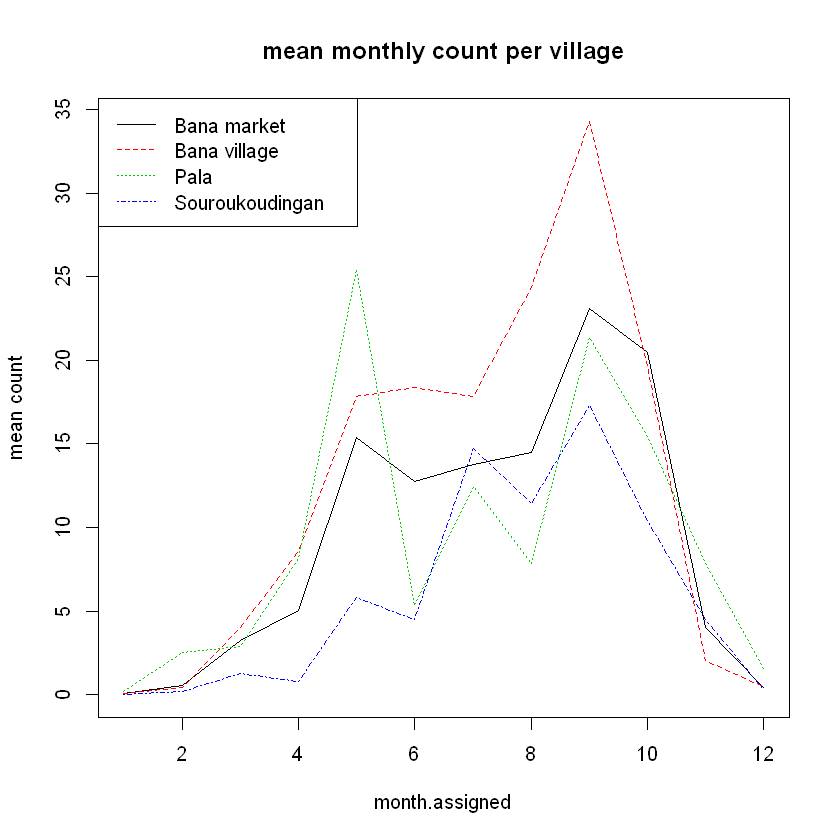

In [16]:
cat('mean monthly count per village')
cbind(month.assigned=levels(dat1$month.assigned), tapply(dat1$count.f, list(dat1$month.assigned, dat1$village), mean, na.rm=T))
matplot(tapply(dat1$count.f, list(dat1$month.assigned, dat1$village), mean, na.rm=T), 
        type='l', xlab='month.assigned', ylab='mean count', main='mean monthly count per village')
legend('topleft', legend=levels(dat1$village), col=1:4, lty=1:4)

Model 5 appears to be a good candidate model for female mosquito counts, given what we have in our dataset. Further simplification may be required. 

In notebook 2 I will perform the same analysis but with wet season data only. 